# Artificial Intelligence
## Recurrent Neural Network Projects

Welcome to the Recurrent Neural Network Project in the Artificial Intelligence!
fill in the blanks

### Implementation TODOs in this notebook

This notebook contains two problems, cut into a variety of TODOs.  Make sure to complete each section containing a ... marker throughout the notebook.  For convinence we provide links to each of these sections below.



# Problem 1: Perform time series prediction 

In this project you will perform time series prediction using a Recurrent Neural Network regressor.  In particular you will re-create the figure shown in the notes - where the stock price of Apple was forecasted (or predicted) 7 days in advance.  In completing this exercise you will learn how to construct RNNs using Keras, which will also aid in completing the second project in this notebook.

The particular network architecture we will employ for our RNN is known as  [Long Term Short Memory (LTSM)](https://en.wikipedia.org/wiki/Long_short-term_memory), which helps significantly avoid technical problems with optimization of RNNs.  

## 1.1 Getting started

First we must load in our time series - a history of around 140 days of Apple's stock price.  Then we need to perform a number of pre-processing steps to prepare it for use with an RNN model.  First off, it is good practice to normalize time series - by normalizing its range.  This helps us avoid serious numerical issues associated how common activation functions (like tanh) transform very large (positive or negative) numbers, as well as helping us to avoid related issues when computing derivatives.

Here we normalize the series to lie in the range [0,1] [using this scikit function](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html), but it is also commonplace to normalize by a series standard deviation.

In [1]:
### Load in necessary libraries for data input and normalization
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

### load in and normalize the dataset
dataset = np.loadtxt('./data2/normalized_apple_prices.csv')

Lets take a quick look at the (normalized) time series we'll be performing predictions on.

Text(0, 0.5, 'normalized series value')

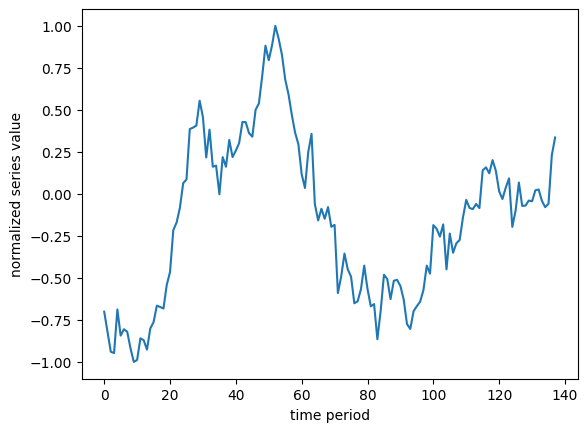

In [2]:
# lets take a look at our time series
plt.plot(dataset)
plt.xlabel('time period')
plt.ylabel('normalized series value')

## 1.2  Cutting our time series into sequences

Remember, our time series is a sequence of numbers that we can represent in general mathematically as 

$$s_{0},s_{1},s_{2},...,s_{P}$$

where $s_{p}$ is the numerical value of the time series at time period $p$ and where $P$ is the total length of the series.  In order to apply our RNN we treat the time series prediction problem as a regression problem, and so need to use a sliding window to construct a set of associated input/output pairs to regress on.  This process is animated in the gif below.

<img src="timeseries.gif" width=600 height=600/>

For example - using a window of size T = 5 (as illustrated in the gif above) we produce a set of input/output pairs like the one shown in the table below

$$\begin{array}{c|c}
\text{Input} & \text{Output}\\
\hline \color{CornflowerBlue} {\langle s_{1},s_{2},s_{3},s_{4},s_{5}\rangle} & \color{Goldenrod}{ s_{6}} \\
\ \color{CornflowerBlue} {\langle s_{2},s_{3},s_{4},s_{5},s_{6} \rangle } & \color{Goldenrod} {s_{7} } \\
\color{CornflowerBlue}  {\vdots} & \color{Goldenrod} {\vdots}\\
\color{CornflowerBlue} { \langle s_{P-5},s_{P-4},s_{P-3},s_{P-2},s_{P-1} \rangle } & \color{Goldenrod} {s_{P}}
\end{array}$$

Notice here that each input is a sequence (or vector) of length 4 (and in general has length equal to the window size T) while each corresponding output is a scalar value.  Notice also how given a time series of length P and window size T = 5 as shown above, we created P - 5  input/output pairs.  More generally, for a window size T we create P - T such pairs.

Now its time for you to window the input time series as described above!  

<a id='TODO_1'></a>

**TODO:** Fill in the function below - called **window_transform_series** - that runs a sliding window along the input series and creates associated input/output pairs.    Note that this function should input a) the series and b) the window length, and return the input/output subsequences.  Make sure to format returned input/output as generally shown in table above (where window_size = 5), and make sure your returned input is a numpy array.

-----

You can test your function on the list of odd numbers given below

In [7]:
odd_nums = np.array([1,3,5,7,9,11,13])
print(int(len(odd_nums)/2))
len(odd_nums)
for i in range(5):
    print(i)

3
0
1
2
3
4


To window this sequence with a window_size = 2 using the **window_transform_series** you should get the following input/output pairs

In [5]:
def window_transform_series(dataset, window_size):
    #Function to run a sliding window of window_size across the dataset
    dataX, dataY = [], []
    for i in range(len(dataset)- window_size):
        a = dataset[i:(i+window_size)]
        dataX.append(a)
        dataY.append(dataset[i + window_size])
        
        # if i < len(dataset) - window_size:

    return np.array(dataX), (np.array(dataY)).reshape(-1,1)

In [8]:
# run a window of size 2 over the odd number sequence and display the results
window_size = 2
X,y = window_transform_series(odd_nums,window_size)

# print out input/output pairs --> here input = X, corresponding output = y
print ('--- the input X will look like ----')
print (X)

print ('--- the associated output y will look like ----')
print (y)

print ('the shape of X is ' + str(np.shape(X)))
print ('the shape of y is ' + str(np.shape(y)))
print('the type of X is ' + str(type(X)))
print('the type of y is ' + str(type(y)))

--- the input X will look like ----
[[ 1  3]
 [ 3  5]
 [ 5  7]
 [ 7  9]
 [ 9 11]]
--- the associated output y will look like ----
[[ 5]
 [ 7]
 [ 9]
 [11]
 [13]]
the shape of X is (5, 2)
the shape of y is (5, 1)
the type of X is <class 'numpy.ndarray'>
the type of y is <class 'numpy.ndarray'>


Again - you can check that your completed **window_transform_series** function works correctly by trying it on the odd_nums sequence - you should get the above output.

-----

With this function in place apply it to the series in the Python cell below.  We use a window_size = 7 for these experiments.

In [27]:
# window the data using your windowing function
window_size = 7
X,y = window_transform_series(dataset = dataset,window_size = window_size)
print(X.shape, y.shape)

(131, 7) (131, 1)


## 1.3  Splitting into training and testing sets

In order to perform proper testing on our dataset we will lop off the last 1/3 of it for validation (or testing).  This is that once we train our model we have something to test it on (like any regression problem!).  This splitting into training/testing sets is done in the cell below.

Note how here we are **not** splitting the dataset *randomly* as one typically would do when validating a regression model.  This is because our input/output pairs *are related temporally*.   We don't want to validate our model by training on a random subset of the series and then testing on another random subset, as this simulates the scenario that we receive new points *within the timeframe of our training set*.  

We want to train on one solid chunk of the series (in our case, the first full 2/3 of it), and validate on a later chunk (the last 1/3) as this simulates how we would predict *future* values of a time series.

In [9]:
# split our dataset into training / testing sets
train_test_split = int(np.ceil(2*len(y)/float(3)))   # set the split point

# partition the training set
X_train = X[:train_test_split,:]
y_train = y[:train_test_split]

# keep the last chunk for testing
X_test = X[train_test_split:,:]
y_test = y[train_test_split:]

# NOTE: to use keras's RNN LSTM module our input must be reshaped to [samples, stepsize, window size] 
X_train = np.asarray(np.reshape(X_train, (X_train.shape[0], 1, window_size)))
X_test = np.asarray(np.reshape(X_test, (X_test.shape[0], 1, window_size)))

<a id='TODO_2'></a>

## 1.4  Build and run an RNN regression model

Having created input/output pairs out of our time series and cut this into training/testing sets, we can now begin setting up our RNN.  We use Keras to quickly build a two hidden layer RNN of the following specifications

- layer 1 uses an LSTM module with 5 hidden units (note here the input_shape = (1,window_size))
- layer 2 uses a fully connected module with one unit
- the 'mean_squared_error' loss should be used (remember: we are performing regression here)

This can be constructed using just a few lines - see e.g., the [general Keras documentation](https://keras.io/getting-started/sequential-model-guide/) and the [LTSM documentation in particular](https://keras.io/layers/recurrent/) for examples of how to quickly use Keras to build neural network models.  Make sure you are initializing your optimizer given the [keras-recommended approach for RNNs](https://keras.io/optimizers/) (given in the cell below).  

In [20]:
### TODO: create required RNN model
# import keras network libraries
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
import keras

# given - fix random seed - so we can all reproduce the same results on our default time series
np.random.seed(0)


# TODO: build an RNN to perform regression on our time series input/output data
model = Sequential()

#LSTM layer with 5 hidden units
model.add(LSTM(5, input_shape=(1, window_size)))

#Dropout added to avoid overfitting
model.add(Dropout(0.2))

#Fully connected layer with one output cell "prediction"
model.add(Dense(1))

# build model using keras documentation recommended optimizer initialization
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# compile the model
model.compile(loss='mse', optimizer=optimizer)


With your model built you can now fit the model by activating the cell below!  Note: the number of epochs (np_epochs) and batch_size are preset (so we can all produce the same results).  You can choose to toggle the verbose parameter - which gives you regular updates on the progress of the algorithm - on and off by setting it to 1 or 0 respectively.

In [32]:
# run your model!
model.fit(X_train, y_train, epochs=10000, batch_size=4, verbose=0)

## 1.5  Checking model performance

With your model fit we can now make predictions on both our training and testing sets.

In [34]:
# generate predictions for training
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


In the next cell we compute training and testing errors using our trained model - you should be able to achieve at least

*training_accuracy* < 0.02

and 

*testing_accuracy* < 0.02

with your fully trained model.  

If either or both of your accuracies are larger than 0.02 re-train your model - increasing the number of epochs you take (a maximum of around 1,000 should do the job) and/or adjusting your batch_size.

In [35]:
# print out training and testing errors
training_accuracy = model.evaluate(X_train, y_train, verbose=0)
print('training accuracy = ' + str(training_accuracy))

testing_accuracy = model.evaluate(X_test, y_test, verbose=0)
print('testing accuracy = ' + str(testing_accuracy))

training accuracy = 0.09234734624624252
testing accuracy = 0.9721208810806274


Activating the next cell plots the original data, as well as both predictions on the training and testing sets. 

In [1]:
### Plot everything - the original series as well as predictions on training and testing sets
import matplotlib.pyplot as plt
%matplotlib inline

# plot original series
plt.plot(dataset,color = 'k')

# plot training set prediction
split_pt = train_test_split + window_size 
plt.plot(np.arange(window_size,split_pt,1),train_predict,color = 'b')

# plot testing set prediction
plt.plot(np.arange(split_pt,split_pt + len(test_predict),1),test_predict,color = 'r')

# pretty up graph
plt.xlabel('day')
plt.ylabel('(normalized) price of Apple stock')
plt.legend(['original series','training fit','testing fit'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

NameError: name 'dataset' is not defined

# exercice 2

Dans cet exercice, vous utiliserez un réseau de neurones récurrent (RNN) pour générer du texte en vous basant sur des extraits de "Antigone" de Jean Anouilh, "La Boîte à merveilles" de Ahmed Sefrioui et "Le Dernier Jour d'un condamné" de Victor Hugo.
1. Préparation des données et Nettoyage
2. Encodage du texte(tokenizer)
3. Construction du modèle RNN(LSTM)
4. Entraînement du modèle
5. Génération de texte

Extrait de texte initial :
« dans le silence de la nuit, je contemplais le ciel étoilé. »

Texte généré par le modèle : « dans le silence de la nuit, je contemplais le ciel étoilé, rêvant aux histoires que ma mère me racontait. chaque étoile semblait briller pour moi, éclairant mon monde intérieur plein de mystères et de merveilles que je ne comprenais pas encore. »

## Préparation des données et Nettoyage
#### Importer les extraits de "Antigone" :

Charger le texte brut à partir d'un fichier [Antigon](./data3/Antigon.txt)
#### Nettoyer le texte :

Convertir le texte en minuscules pour homogénéiser.
Supprimer les caractères spéciaux, la ponctuation inutile ou les chiffres.
Réduire les espaces multiples.

In [ ]:
import re

# Charger le texte
with open("./data3/Antigon.txt", "r", encoding="utf-8") as file:
    text = file.read()

# Nettoyage
text = text.lower()
text = re.sub(r"[^\w\s]", "", text)  # Supprimer la ponctuation
text = re.sub(r"\s+", " ", text)     # Supprimer les espaces multiples
print(text)

anouilh antigone personnages antigone fille doedipe créon roi de thèbes hémon fils de créon ismène fille doedipe le choeur la nourrice le messager les gardes le prologue decor un décor neutre trois portes semblables au lever du rideau tous les personnages sont en scène ils bavardent tricotent jouent aux cartes le prologue se détache et savance le prologue voilà ces personnages vont vous jouer lhistoire dantigone antigone cest la petite maigre qui est assise làbas et qui ne dit rien elle regarde droit devant elle elle pense elle pense quelle va être antigone tout à lheure quelle va surgir soudain de la maigre jeune fille noiraude et renfermée que personne ne prenait au sérieux dans la famille et se dresser seule en face du monde seule en face de créon son oncle qui est le roi elle pense quelle va mourir quelle est jeune et quelle aussi elle aurait bien aimé vivre mais il ny a rien à faire elle sappelle antigone et il va falloir quelle joue son rôle jusquau bout et depuis que ce rideau s

2. Encodage du texte (Tokenizer)
Créer un dictionnaire de caractères ou de mots :

Convertir les caractères (ou mots) uniques en indices pour qu'ils puissent être compris par le modèle.
Fractionner le texte :

Générer des séquences de longueur fixe pour entraîner le modèle.

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
import numpy as np

# Tokenizer pour les caractères
tokenizer = Tokenizer(char_level=True)  # Choisir char_level=True pour caractères
tokenizer.fit_on_texts([text])

# Convertir le texte en séquences d'indices
total_chars = len(tokenizer.word_index)
encoded_text = tokenizer.texts_to_sequences([text])[0]

# Créer des séquences d'entrée et de sortie
seq_length = 40  # Longueur de chaque séquence
sequences = []
for i in range(seq_length, len(encoded_text)):
    seq_in = encoded_text[i - seq_length:i]
    seq_out = encoded_text[i]
    sequences.append((seq_in, seq_out))

# Convertir en numpy array
X = np.array([x for x, _ in sequences])
y = to_categorical([y for _, y in sequences], num_classes=total_chars + 1)


3. Construction du modèle RNN (LSTM)
Créer un modèle avec LSTM :

Ajouter une couche d'entrée, une couche LSTM, et une couche de sortie dense.

In [15]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding

# Construire le modèle
model = Sequential()
model.add(Embedding(total_chars + 1, 50, input_length=seq_length))  # Embedding pour les caractères
model.add(LSTM(150, return_sequences=True))
model.add(LSTM(150))
model.add(Dense(total_chars + 1, activation="softmax"))

# Compiler
model.compile(loss="categorical_crossentropy", optimizer="adam")
model.summary()


/home/youssef/Desktop/Labs_Deep_Learning/venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2024-11-16 16:28:56.530770: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

4. Entraînement du modèle
Définir les paramètres d'entraînement :

Utiliser des epochs et un batch size appropriés.
Lancer l'entraînement :

Suivre la progression avec validation_split

In [16]:
model.fit(X, y, epochs=20, batch_size=128, validation_split=0.2)

Epoch 1/20
544/544 ━━━━━━━━━━━━━━━━━━━━ 241s 433ms/step - loss: 2.7028 - val_loss: 2.0865
Epoch 2/20
544/544 ━━━━━━━━━━━━━━━━━━━━ 241s 394ms/step - loss: 2.0226 - val_loss: 1.8832
Epoch 3/20
544/544 ━━━━━━━━━━━━━━━━━━━━ 191s 351ms/step - loss: 1.8344 - val_loss: 1.7556
Epoch 4/20
544/544 ━━━━━━━━━━━━━━━━━━━━ 189s 348ms/step - loss: 1.7060 - val_loss: 1.6591
Epoch 5/20
544/544 ━━━━━━━━━━━━━━━━━━━━ 198s 363ms/step - loss: 1.6219 - val_loss: 1.6060
Epoch 6/20
544/544 ━━━━━━━━━━━━━━━━━━━━ 189s 347ms/step - loss: 1.5517 - val_loss: 1.5582
Epoch 7/20
544/544 ━━━━━━━━━━━━━━━━━━━━ 200s 343ms/step - loss: 1.4799 - val_loss: 1.5216
Epoch 8/20
544/544 ━━━━━━━━━━━━━━━━━━━━ 189s 348ms/step - loss: 1.4291 - val_loss: 1.5050
Epoch 9/20
544/544 ━━━━━━━━━━━━━━━━━━━━ 199s 342ms/step - loss: 1.3962 - val_loss: 1.4737
Epoch 10/20
544/544 ━━━━━━━━━━━━━━━━━━━━ 192s 352ms/step - loss: 1.3537 - val_loss: 1.4537
Epoch 11/20
544/544 ━━━━━━━━━━━━━━━━━━━━ 200s 348ms/step - loss: 1.3112 - val_loss: 1.4459
Epoch 12

5. Génération de texte
Définir une fonction pour générer du texte :

Utiliser un seed (graine) pour initialiser la génération.
Prédire caractère par caractère.

In [19]:
def generate_text(model, tokenizer, seed_text, num_chars=200):
    # Compléter ou tronquer la graine
    if len(seed_text) < seq_length:
        seed_text = seed_text.rjust(seq_length)  # Complète avec des espaces
    else:
        seed_text = seed_text[-seq_length:]     # Tronque la graine

    result = seed_text
    for _ in range(num_chars):
        # Encoder la graine
        encoded = tokenizer.texts_to_sequences([result[-seq_length:]])[0]
        encoded = np.array(encoded).reshape(1, seq_length)

        # Prédire le prochain caractère
        predicted = model.predict(encoded, verbose=0)
        next_index = np.argmax(predicted)
        next_char = tokenizer.sequences_to_texts([[next_index]])[0]

        # Ajouter le caractère prédit
        result += next_char

    return result


In [23]:
# Exemple de génération
seed = "Il ne reste plus que les"
generated_text = generate_text(model, tokenizer, seed)
print(generated_text)

                Il ne reste plus que les autres au monde antigone sourit et le chaud de mon frère que tu sais pas ce que tu sais pas ce que tu sais pas ce que tu sais pas ce que tu sais pas ce que tu sais pas ce que tu sais pas ce que tu sa
